# 4. No pretrained model

Our last attempt will be to create a custom model without using a pretrained model. We will use our knowledge from tutorials. 

In [1]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from keras import regularizers

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import numpy as np

In [2]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda vesion:', cuda_version)
cudnn_version = sys_details["cudnn_version"]  
print('Cudnn vesion:', cudnn_version)

Cuda vesion: 11.2
Cudnn vesion: 8


## Preparation and model creation
Uncomment the configuration that you would like to train.

In [3]:
# _train_dir = 'resized128/train'
# _test_dir = 'resized128/test'
# _img_width, _img_height = 128,128 
# _batch_size = 32
# _weights_name = 'maskedfaces128_no_pretrained.h5'

In [3]:
_train_dir = 'resized224/train'
_test_dir = 'resized224/test'
_img_width, _img_height = 224,224 
_batch_size = 32
_weights_name = 'maskedfaces224_no_pretrained.h5'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    _train_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    _train_dir, # same directory as training data
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 96659 images belonging to 2 classes.
Found 17056 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(
    rescale=1./255) 

test_generator = train_datagen.flow_from_directory(
    _test_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary')

Found 20067 images belonging to 2 classes.


In [6]:
# fisrt try was overfitting :(
# model = Sequential()
# model.add(Conv2D(_img_width/2, (3, 3), padding='same', activation='relu', input_shape=(_img_width, _img_height, 3)))
# model.add(BatchNormalization(axis=1))
# model.add(Conv2D(_img_width/2, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.20))

# model.add(Conv2D(_img_width, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(Conv2D(_img_width, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.20))

# model.add(Conv2D(_img_width*2, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(Conv2D(_img_width*2, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.20))

# model.add(Conv2D(_img_width*4, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(Conv2D(_img_width*4, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.20))

# model.add(Flatten())
# model.add(Dense(_img_width*8, activation='relu'))
# model.add(Dense(_img_width*4, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001),  metrics=['accuracy'])
# model.summary()

In [6]:
model = Sequential()
model.add(Conv2D(64, (4, 4), padding='same', activation='relu', input_shape=(_img_width, _img_height, 3), kernel_regularizer=regularizers.l2(l=0.01), kernel_initializer='he_normal'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), kernel_initializer='he_normal'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001),  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     896       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      9232      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 16)     4

2021-12-30 17:10:41.218114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 17:10:41.750175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9584 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


## Training the model
We have also added a checkpoint save weights with the best validation loss. You can also [skip](#skip) the training.

In [7]:
checkpointer = ModelCheckpoint(filepath=_weights_name, verbose=1, save_best_only=True)

We will train the model for 15 epochs.

In [ ]:
hist = model.fit(train_generator, validation_data = valid_generator, epochs=15, callbacks=[checkpointer], verbose=True)

Epoch 1/15


2021-12-30 17:10:49.930403: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


3021/3021 [==============================] - ETA: 0s - loss: 0.8888 - accuracy: 0.9719
Epoch 00001: val_loss improved from inf to 0.45055, saving model to maskedfaces224_no_pretrained.h5
3021/3021 [==============================] - 1079s 356ms/step - loss: 0.8888 - accuracy: 0.9719 - val_loss: 0.4506 - val_accuracy: 0.9576
Epoch 2/15
3021/3021 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9896
Epoch 00002: val_loss improved from 0.45055 to 0.14368, saving model to maskedfaces224_no_pretrained.h5
3021/3021 [==============================] - 1061s 351ms/step - loss: 0.2023 - accuracy: 0.9896 - val_loss: 0.1437 - val_accuracy: 0.9874
Epoch 3/15
3021/3021 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9907
Epoch 00003: val_loss improved from 0.14368 to 0.11461, saving model to maskedfaces224_no_pretrained.h5
3021/3021 [==============================] - 1046s 346ms/step - loss: 0.1002 - accuracy: 0.9907 - val_loss: 0.1146 - val_accuracy: 0.

Now we will plot the training history and evaluate our model on test data.

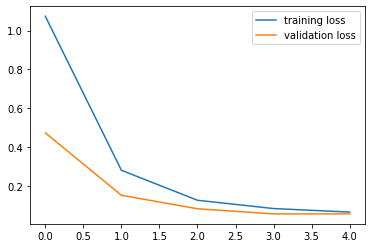

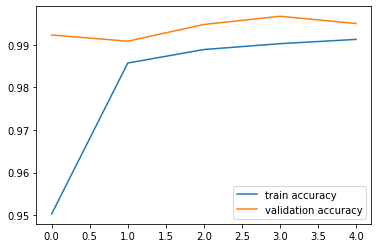

In [10]:
plt.figure()
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

<a id='skip'></a> If you want to skip the training, just uncomment the first or the second cell under this text. But don't forget to recompile the model with desired (128/224) configuration.

In [11]:
# !wget https://data.belanec.eu/maskedface/weights/maskedfaces128_no_pretrained.h5
# _weights_name = 'maskedfaces128_no_pretrained.h5'

In [ ]:
# !wget https://data.belanec.eu/maskedface/weights/maskedfaces224_no_pretrained.h5
# _weights_name = 'maskedfaces224_no_pretrained.h5'

In [12]:
model.load_weights(_weights_name)

In [13]:
train_score = model.evaluate(train_generator)
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(test_generator)
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

3021/3021 [==============================] - 356s 118ms/step - loss: 0.0572 - accuracy: 0.9969


train loss: 0.05719519406557083 | train acc: 0.9968755841255188

628/628 [==============================] - 80s 127ms/step - loss: 0.0562 - accuracy: 0.9975


test loss: 0.05621125176548958 | test acc: 0.9975083470344543


In [14]:
model_predictions = model.predict(test_generator)

In [17]:
preds = np.array(model_predictions > 0.5).astype(int).T[0]
labels = np.array(test_generator.classes)

f1 = f1_score(labels, preds)
print('F1 score: ', f1)

F1 score:  0.4994768050226718


## Conclusion

Our model with pretrained Xception model with disabled learning ended up with much better accuracy. The F1 score is still poor. The training of this model was around 6 minutes per epoch on 128x128 images and around 20 minutes per epoch on 224x224 images.

### 224x224 images
Our custom model with 224x224 images ended up with results:
- train loss: 
- train accuracy: 
- test loss: 
- test accuracy: 
- F1 score: 

### 128x128 images
Our custom model with 128x128 images ended up with results:
- train loss: 0.06
- train accuracy: 0.99
- test loss: 0.06
- test accuracy: 0.99
- F1 score: 0.5 